## Intro 
In this notebook we will apply knowledge gathered from previous analysis to kegg ortologs, this dataset is focused on even lower level biounits than bacteria famillies and pathways, and thus we have much more features, this means we can utilise 1D CNN networks in order to try to reduce number of parameters in the model, We have to remember that CNN try to find structural patterns and we dont necccesarily have ones in our dataset as positioning of columns is random. Nevertheless we decided to test this approach   

### Import libraries and load data

In [1]:
#libraries import
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
# for tensorboard logs
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import normalize
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split, KFold
from functions import *
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE, SMOTEN
from keras.layers import Dense, Dropout, Activation, Flatten
np.random.seed(111)
tf.random.set_seed(111)


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/paq88/Fish_neural_network_classifier/refs/heads/main/sed_based/Data/sed_KEGG_ortholog_merged.csv')


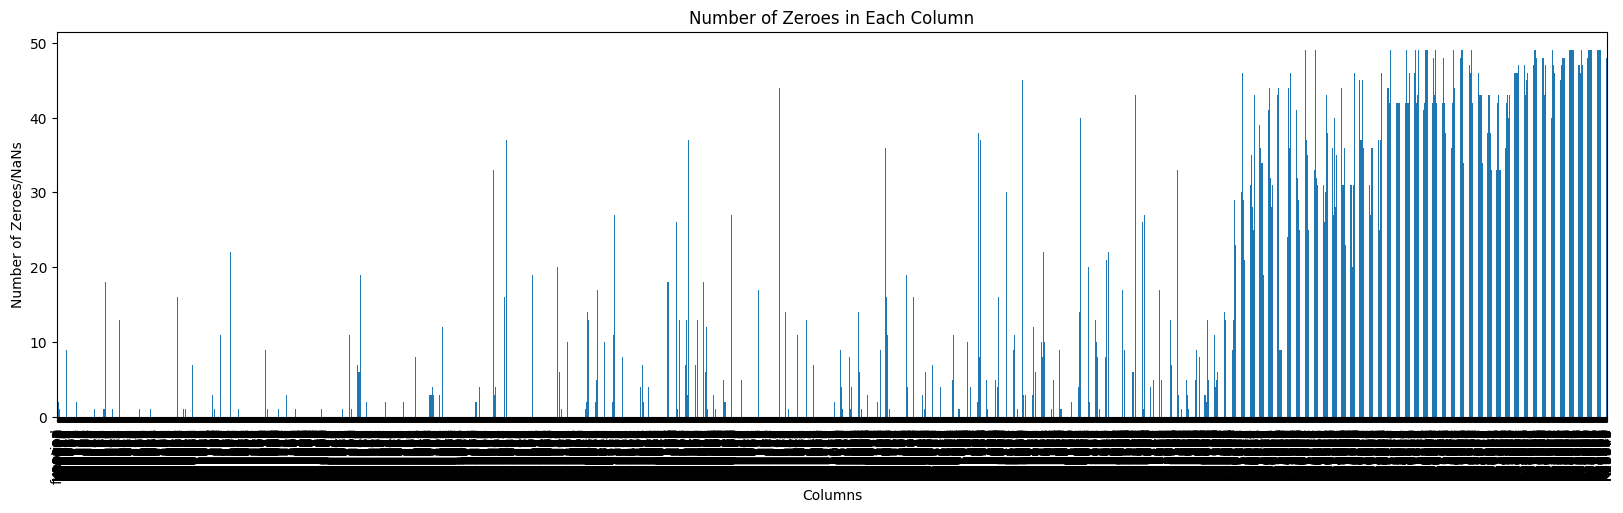

In [3]:
zero_counts = ((df == 0) | (df.isna())).sum()
zero_counts.plot(kind='bar', figsize=(20, 5))
plt.xlabel('Columns')
plt.ylabel('Number of Zeroes/NaNs')
plt.title('Number of Zeroes in Each Column')
plt.show()

Judnging from this plot we dont have that much missing observations this means that in sediment dataset which we have here most of the organisms lived in most of the ponds, we also have a big set of organisms that lived onyly in one kind of setup, This should give model enough information to classify.

In [4]:
print(df.shape)
df.head()

(50, 6370)


,pond,function,K00001,K00002,K00003,K00004,K00005,K00006,K00007,K00008,...,K19734,K19744,K03955,K06157,K07450,K07682,K12567,K15643,K16875,K18376
0,S29,S29.209.Sed,1111.21,26.0,2778.48,125.0,170.0,10.0,12.0,897.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,S29,S29.210.Sed,393.50,17.0,1221.01,31.0,145.0,0.0,0.0,448.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,S27,S27.239.Sed,782.34,40.0,1608.34,56.5,135.0,65.0,13.0,771.83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,S27,S27.240.Sed,763.34,31.5,2032.50,80.5,187.5,0.0,8.0,717.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,S28,S28.225.Sed,1039.50,34.5,2696.00,79.0,238.5,38.0,37.0,1065.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
ID = df['function'].str.split('.').apply(lambda x: x[1] if len(x) > 1 else None)
df.insert(1, 'ID', ID)

In [6]:
df.sort_values('ID', inplace=True)

In [9]:
df

,pond,ID,function,K00001,K00002,K00003,K00004,K00005,K00006,K00007,...,K19734,K19744,K03955,K06157,K07450,K07682,K12567,K15643,K16875,K18376
18,S08,201,S8.201.Sed,1159.84,19.50,2516.72,104.00,104.00,25.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,S08,202,S8.202.Sed,1941.66,196.50,3301.84,162.00,633.00,0.0,81.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,S14,203,S14.203.Sed,750.50,0.00,2195.99,86.50,22.33,99.0,11.5,...,NaN,NaN,NaN,0.0,11.0,11.0,0.0,0.0,1.33,0.0
47,S14,204,S14.204.Sed,1283.44,36.00,3120.13,153.00,330.58,20.0,110.5,...,NaN,NaN,NaN,15.0,0.0,0.0,12.0,12.0,8.33,12.0
15,S18,205,S18.205.Sed,1111.16,12.26,3069.75,134.50,10.52,18.0,107.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,S18,206,S18.206.Sed,172.00,19.50,742.99,31.50,231.50,0.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,S24,207,S24.207.Sed,1180.91,15.00,3395.41,157.00,7.50,135.0,78.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,S24,208,S24.208.Sed,632.50,60.50,1636.00,119.00,279.66,0.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,S29,209,S29.209.Sed,1111.21,26.00,2778.48,125.00,170.00,10.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,S29,210,S29.210.Sed,393.50,17.00,1221.01,31.00,145.00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
predictors = df.columns[3:]
print(f"number of predictors/bacteria famillies: {len(predictors)}")
      
# adding collumn with timepoints 
classes = np.tile([0, 1], 25)
df.insert(1,"timepoint",  classes)

# replacing NaN values with 0
df.fillna(0, inplace=True)

df.head()



number of predictors/bacteria famillies: 6368


,pond,timepoint,ID,function,K00001,K00002,K00003,K00004,K00005,K00006,...,K19734,K19744,K03955,K06157,K07450,K07682,K12567,K15643,K16875,K18376
18,S08,0,201,S8.201.Sed,1159.84,19.50,2516.72,104.0,104.00,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
19,S08,1,202,S8.202.Sed,1941.66,196.50,3301.84,162.0,633.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
46,S14,0,203,S14.203.Sed,750.50,0.00,2195.99,86.5,22.33,99.0,...,0.0,0.0,0.0,0.0,11.0,11.0,0.0,0.0,1.33,0.0
47,S14,1,204,S14.204.Sed,1283.44,36.00,3120.13,153.0,330.58,20.0,...,0.0,0.0,0.0,15.0,0.0,0.0,12.0,12.0,8.33,12.0
15,S18,0,205,S18.205.Sed,1111.16,12.26,3069.75,134.5,10.52,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0


In [12]:
df.drop(columns=['function'], inplace=True)

In [13]:
# for normalisation we will use starndard min-max normalisation
scaler = MinMaxScaler()
df[predictors] = scaler.fit_transform(df[predictors])




| number | setup | pond numbers | water supplementation | feed supplementation |
|---|---|---|---|---|
|0|control | 8,14,18,24,29|NO|NO|
|1|set 1 | 12,16,19,23,26|Em farma|NO|
|2|set 2 | 10,21,28,30,32|Em farma|EM|
|3|set 3 | 9,13,17,20,27|EM|NO|
|4|set 4 | 11,15,22,25,31|EM|EM|

In [14]:
df['pond_org'] = df['pond']

C:\Users\marek\AppData\Local\Temp\ipykernel_24620\3039816547.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['pond_org'] = df['pond']


In [16]:
# Decoding use pond decoder 2 for this

codes = {0 : [8,14,18,24,29], 1: [12,16,19,23,26], 2 : [10,21,28,30,32], 3 : [9,13,17,20,27], 4 : [11,15,22,25,31]}


    

df['pond']=df['pond_org'].apply(lambda x: pond_decoder(x, codes))


In [18]:
# defragmenting 
df = df.copy()

In [54]:
#train_val_df, test_df = train_test_split(df, test_size= 10, random_state=111, stratify=df['pondXtime'])
#print(train_val_df.shape, test_df.shape)

### Definitions

In [19]:
kf = KFold(n_splits=5, shuffle=True, random_state=111)


In [20]:
# early stopping callback to save the best model weights for test set
es_callback = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=100,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Verbosity mode
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

### Modeling timepoints
First thing that we are going to try is the only thing that worked properly wchich is modeling timepoints only.

In [24]:
model0 = keras.Sequential()
model0.add(keras.layers.Dense(1024,input_shape=(len(predictors),),activation='relu'))
model0.add(keras.layers.Dense(254, activation ='relu'))
model0.add(keras.layers.Dropout(rate=0.25))
model0.add(keras.layers.Dense(128, activation ='relu'))

model0.add(keras.layers.Dense(64, activation ='relu'))
model0.add(keras.layers.Dense(16, activation ='relu'))
model0.add(keras.layers.Dropout(rate=0.25))
model0.add(keras.layers.Dense(16, activation ='relu'))

model0.add(keras.layers.Dense(2, activation ='softmax'))

print(model0.summary())


loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model0.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 1024)           │     6,521,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 254)            │       260,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 254)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,824,448 (26.03 MB)

 Trainable params: 6,824,448 (26.03 MB)

 Non-trainable params: 0 (0.00 B)

None


Number of classes: 2
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 0.0037
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
predicted classes:       [0 0 1 1 0 1 1 0 1 0]
true validation classes: [0 0 1 1 0 1 1 0 1 0]
mean confidence score: 3.77474905725914e+26, sd confidence score: 1.1250013001197722e+27
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9000 - loss: 0.2012
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
predicted classes:       [1 0 1 1 1 1 0 0 1 1]
true validation classes: [1 0 1 1 1 1 0 0 1 0]
mean confidence score: 284647536377127.0, sd confidence score: 853942603989234.6
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 3.5087e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
predicted classes:       [1 0 0 1 1 0 1 0 1 1]
true validation classes: [1 0 0 1 1 0 1 0 1 1]
mean confidence score: inf, sd confidence score: nan
training for 4 subset


c:\Users\marek\My Drive\Ryby\Ryby\sed_based\functions.py:115: RuntimeWarning: divide by zero encountered in scalar divide
  confidence_score = round(((highest / mean)-1),4)
C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9000 - loss: 1.7400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
predicted classes:       [1 1 1 0 0 1 0 0 1 0]
true validation classes: [1 1 0 0 0 1 0 0 1 0]
mean confidence score: 9.30803927530104e+25, sd confidence score: 2.7924116584247287e+26
training for 5 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 3.2186e-07
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
predicted classes:       [0 0 1 0 0 0 1 0 1 1]
true validation classes: [0 0 1 0 0 0 1 0 1 1]
mean confidence score: 2.3157443849191875e+33, sd confidence score: 6.947233085310062e+33
validation set mean accuracy: 0.96, sd0.049, mean loss: 0.3891, sd: 0.6799
global mean confidence score: inf, sd confidence score: nan


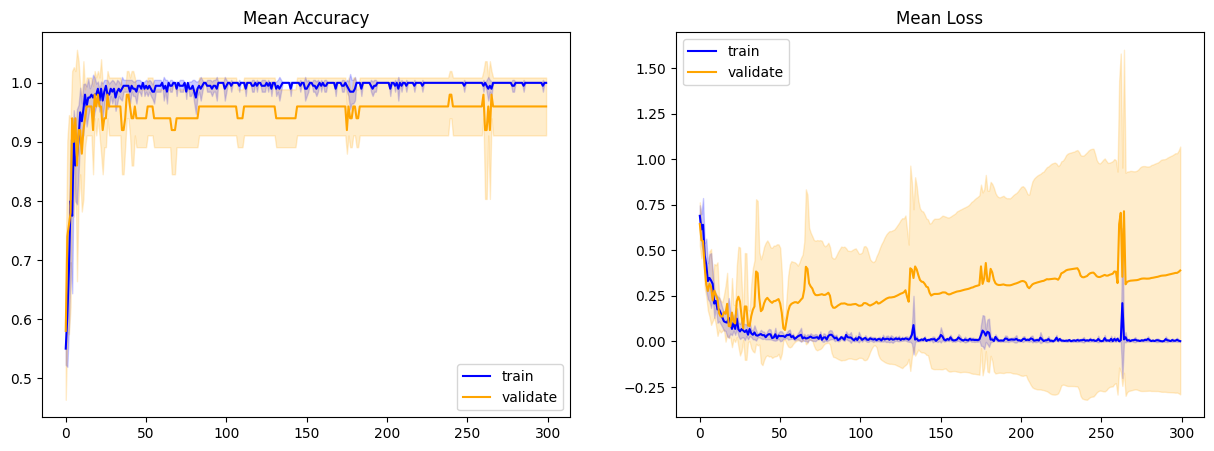

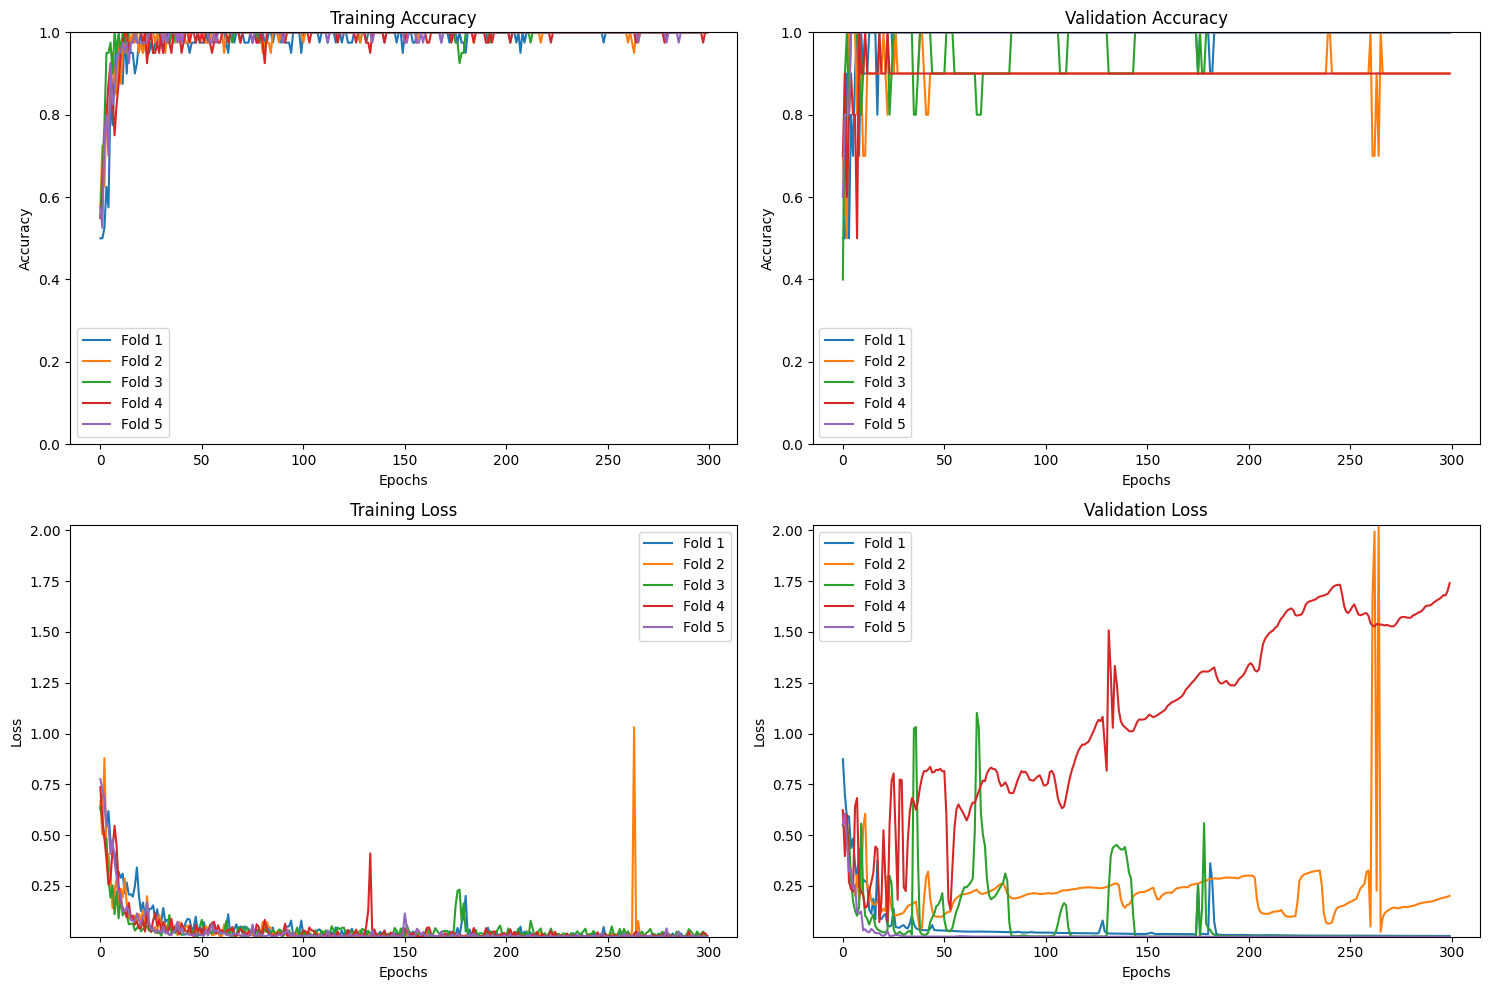

In [25]:
crossvalidate(df, model0, predictors, 'timepoint', kf)

As we can see for KO dataset it worked perfectly as well, the model is much bigger and thus the loss functions are fluctuating much more but we have very nice accuracy. It is worth mentioning that we have only one sample per pond per timepoint so there is no replication of samples. and that means that the differences between timepoints seems to be significant. Now we will try to check if CNN's give similar results.

In [26]:
model0c = keras.Sequential()

model0c.add(keras.layers.Conv1D(filters=3, kernel_size=5, activation='relu',input_shape = (len(predictors),1)))
model0c.add(keras.layers.Conv1D(filters=2, kernel_size=3, activation='relu'))


model0c.add(Flatten())

model0c.add(keras.layers.Dense(1024, activation ='relu'))
model0c.add(keras.layers.Dense(254, activation ='relu'))
model0c.add(keras.layers.Dropout(rate=0.25))

model0c.add(keras.layers.Dense(128, activation ='relu'))

model0c.add(keras.layers.Dense(64, activation ='relu'))
model0c.add(keras.layers.Dense(16, activation ='relu'))
model0c.add(keras.layers.Dropout(rate=0.25))
model0c.add(keras.layers.Dense(16, activation ='relu'))

model0c.add(keras.layers.Dense(2, activation ='softmax'))

print(model0c.summary())


loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model0c.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 6364, 3)        │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 6362, 2)        │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12724)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1024)           │    13,030,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 254)            │       260,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 254)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,333,030 (50.86 MB)

 Trainable params: 13,333,030 (50.86 MB)

 Non-trainable params: 0 (0.00 B)

None


Number of classes: 2
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 1.0000 - loss: 2.8690e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
predicted classes:       [0 0 1 1 0 1 1 0 1 0]
true validation classes: [0 0 1 1 0 1 1 0 1 0]
mean confidence score: 4489703766422.736, sd confidence score: 10570388582430.484
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.0059
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
predicted classes:       [1 0 1 1 1 1 0 0 1 0]
true validation classes: [1 0 1 1 1 1 0 0 1 0]
mean confidence score: 18854780861835.582, sd confidence score: 56564336121382.555
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0016
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
predicted classes:       [1 0 0 1 1 0 1 0 1 1]
true validation classes: [1 0 0 1 1 0 1 0 1 1]
mean confidence score: 3.536296145057128e+16, sd confidence score: 1.0572802610966518e+17
training for 4 subset
1/1 ━━━━━━━━━━━━━━

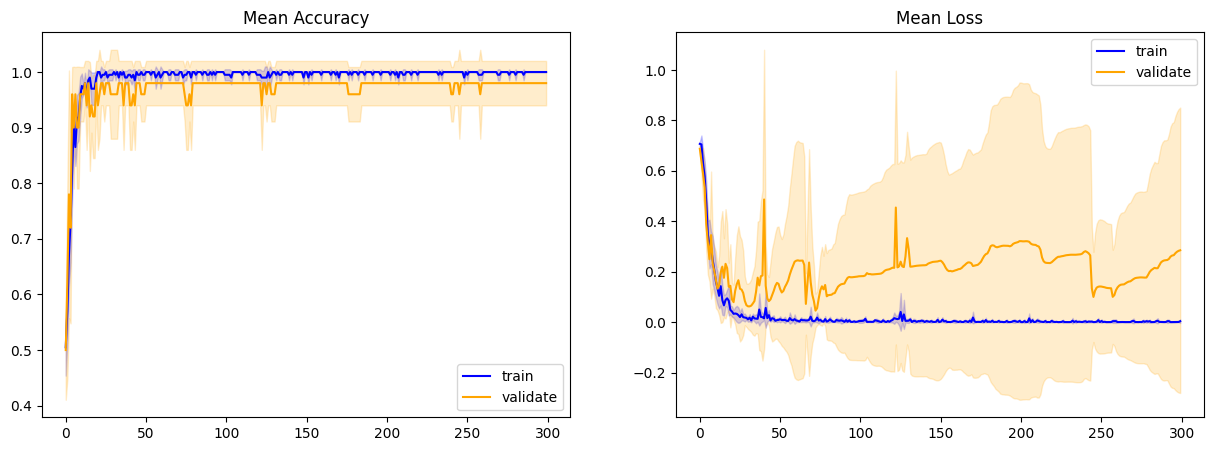

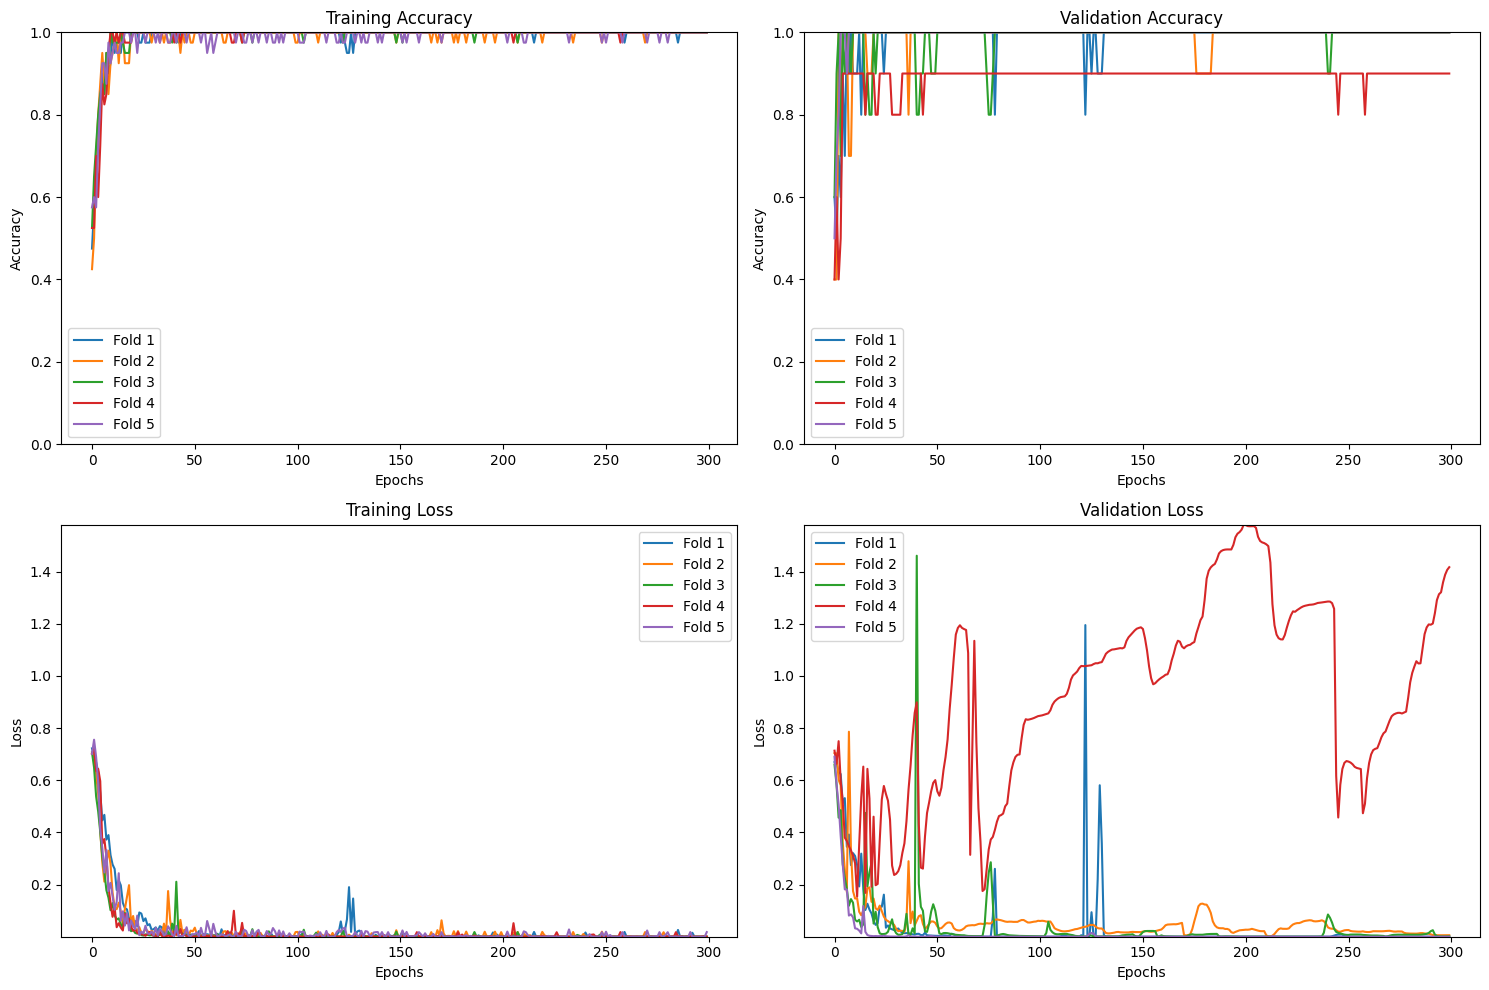

In [27]:
crossvalidate(df, model0c, predictors, 'timepoint', kf)

Convolutional approach proved to yield same results as non convolutional having very good accuracy for all the folds.

### Convolution only ponds

In [28]:
model2 = keras.Sequential()

model2.add(keras.layers.Conv1D(filters=3, kernel_size=5, activation='relu',input_shape = (len(predictors),1)))
model2.add(keras.layers.Conv1D(filters=2, kernel_size=3, activation='relu'))


model2.add(Flatten())

model2.add(keras.layers.Dense(1024, activation ='relu'))
model2.add(keras.layers.Dense(254, activation ='relu'))
model2.add(keras.layers.Dropout(rate=0.25))

model2.add(keras.layers.Dense(128, activation ='relu'))

model2.add(keras.layers.Dense(64, activation ='relu'))
model2.add(keras.layers.Dense(16, activation ='relu'))
model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(16, activation ='relu'))

model2.add(keras.layers.Dense(5, activation ='softmax'))

print(model2.summary())


loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 6364, 3)        │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 6362, 2)        │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12724)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1024)           │    13,030,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 254)            │       260,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 254)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        32,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,333,081 (50.86 MB)

 Trainable params: 13,333,081 (50.86 MB)

 Non-trainable params: 0 (0.00 B)

None


Number of classes: 5
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.3000 - loss: 6.7183
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
predicted classes:       [4 1 3 4 4 0 3 4 3 3]
true validation classes: [0 1 1 2 3 3 3 3 3 4]
mean confidence score: 15353.2373, sd confidence score: 35182.272
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.1000 - loss: 1.9544
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
predicted classes:       [3 3 4 3 0 3 1 0 3 4]
true validation classes: [0 0 0 1 1 2 3 3 4 4]
mean confidence score: 15.2399, sd confidence score: 29.3553
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.1000 - loss: 4.9364
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
predicted classes:       [1 4 1 1 0 1 4 2 1 1]
true validation classes: [0 0 0 1 2 2 2 3 3 4]
mean confidence score: 298.9407, sd confidence score: 494.4178
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3000 - loss: 3.2140
1/1 ━━━━━━━━━━━━

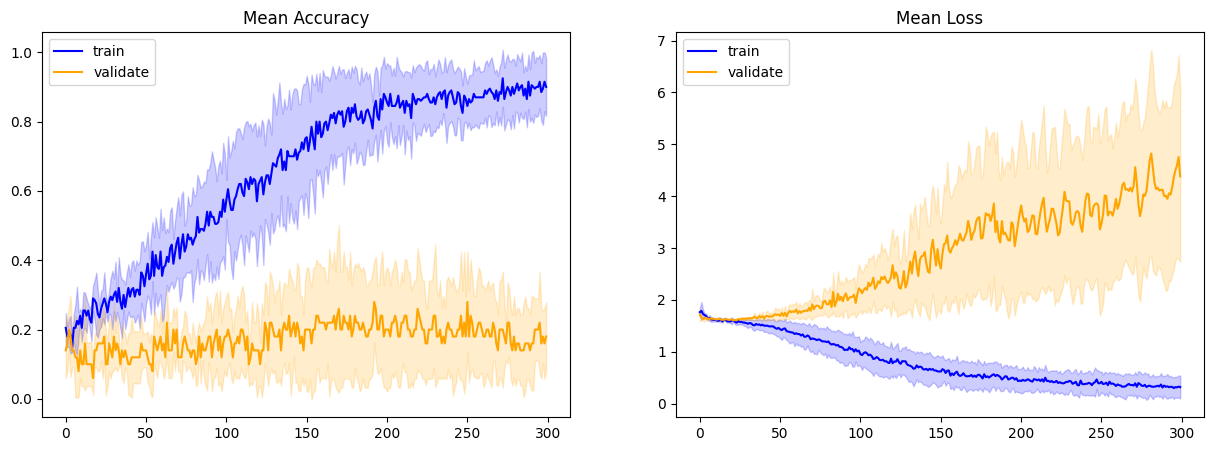

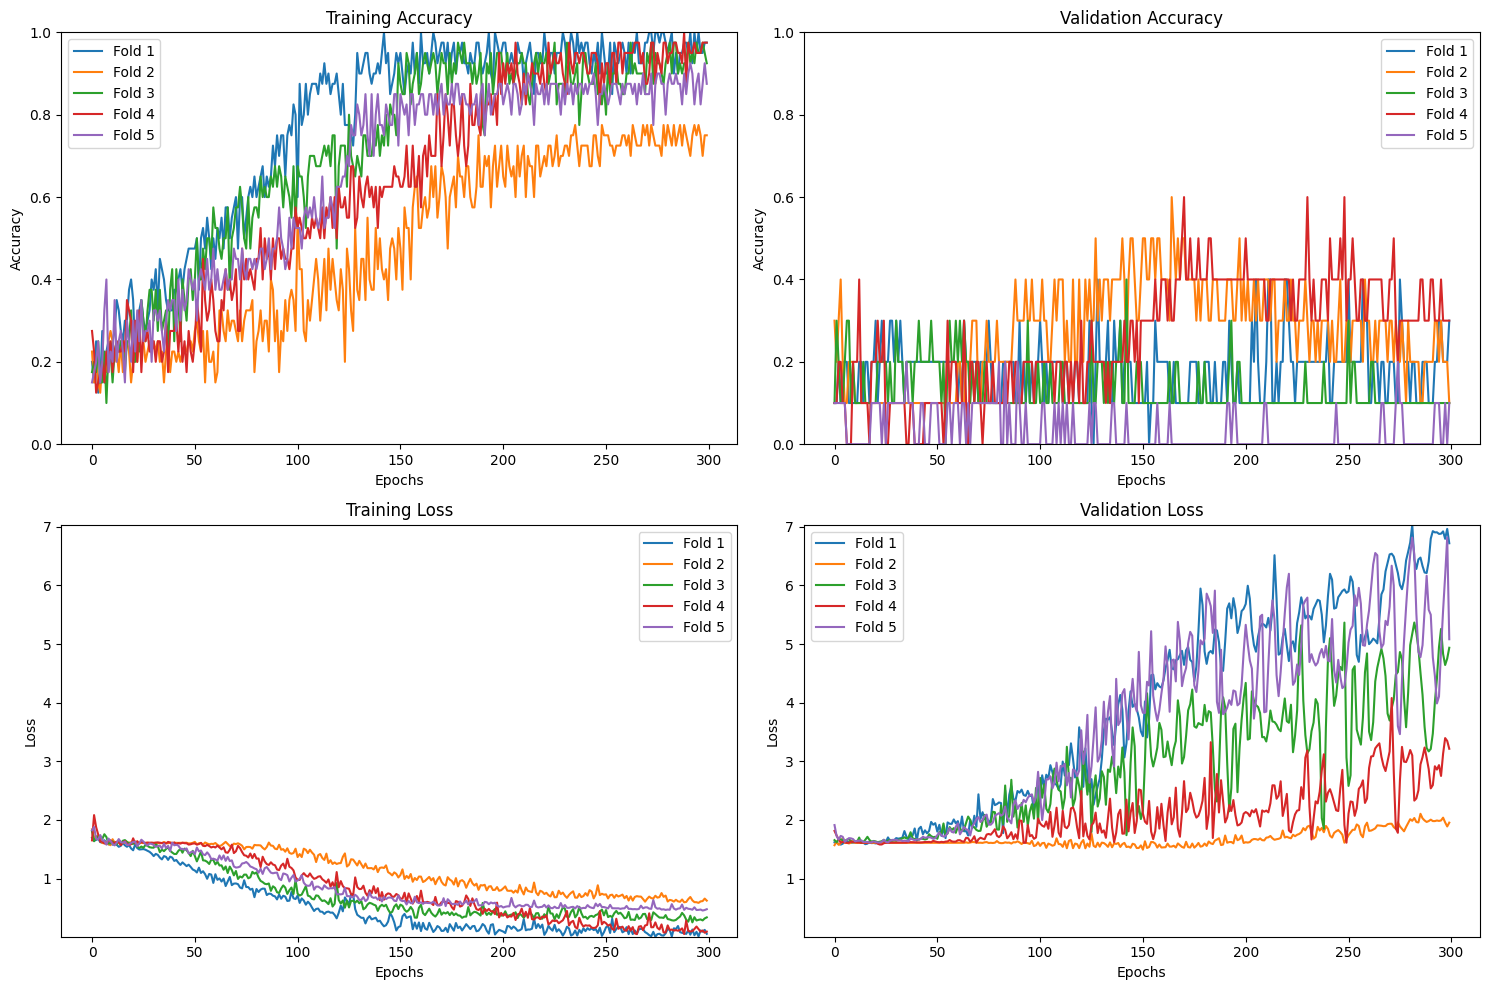

In [29]:
crossvalidate(df, model2, predictors, 'pond', kf, True)

XXXXXX

### Oversampling 1:4 classes
For oversampling we will again use SMOTE algorythm as it is more sophisticated than just duplicating.

In [120]:
train_val_df, test_df = train_test_split(df, test_size= 10, random_state=111, stratify=df['class'])
train_val_df.shape, test_df.shape

((40, 6372), (10, 6372))

In [121]:
smote = SMOTE(random_state=111, sampling_strategy='not majority', k_neighbors=3)
X = train_val_df[predictors].values
y = train_val_df['class']

 

In [122]:
# Ensure y contains discrete class labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_smote, y_smote = smote.fit_resample(X, y_encoded)

In [123]:
print(X.shape, y.shape)
print(X_smote.shape, y_smote.shape)

(40, 6368) (40,)
(120, 6368) (120,)


In [124]:
df_smote = pd.concat([pd.DataFrame(X_smote, columns=predictors), pd.DataFrame(y_smote, columns=['class'])], axis=1)
df_smote['class'].value_counts()

class
0    24
4    24
3    24
1    24
2    24
Name: count, dtype: int64

#### Modeling oversampled dataset

In [27]:
model2 = keras.Sequential()



model2.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))


model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(64, activation ='sigmoid'))
model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(16, activation ='sigmoid'))

model2.add(keras.layers.Dense(5, activation ='softmax'))

model2.summary()

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 256)            │     1,630,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,648,037 (6.29 MB)

 Trainable params: 1,648,037 (6.29 MB)

 Non-trainable params: 0 (0.00 B)

Number of classes: 5
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.1375
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
predicted classes:       [0 4 3 1 1 0 0 0 0 0 0 1 1 2 3 3 3 3 3 3 3 4 4 4]
true validation classes: [0 4 3 1 1 0 0 0 0 0 0 1 1 2 3 3 3 3 3 3 3 4 4 4]
mean confidence score: 39.494, sd confidence score: 17.9281
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0954
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted classes:       [0 2 0 3 1 1 1 1 1 1 1 2 2 2 2 2 3 3 3 3 4 4 4 4]
true validation classes: [0 2 0 3 1 1 1 1 1 1 1 2 2 2 2 2 3 3 3 3 4 4 4 4]
mean confidence score: 45.931, sd confidence score: 16.91
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9167 - loss: 0.3237
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted classes:       [0 3 3 2 1 1 1 1 2 2 2 2 3 3 3 3 3 4 4 4 4 4 4 4]
true validation classes: [0 3 0 2 0 1 1 1 2 2 2 2 3 3 3 3 3 4 4 4 4 4 4 4]
mean confidence

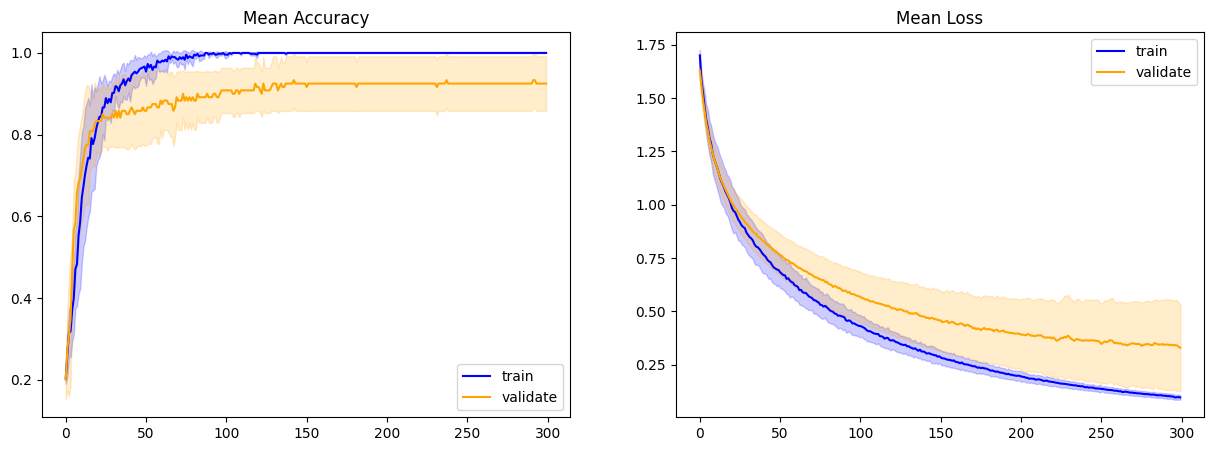

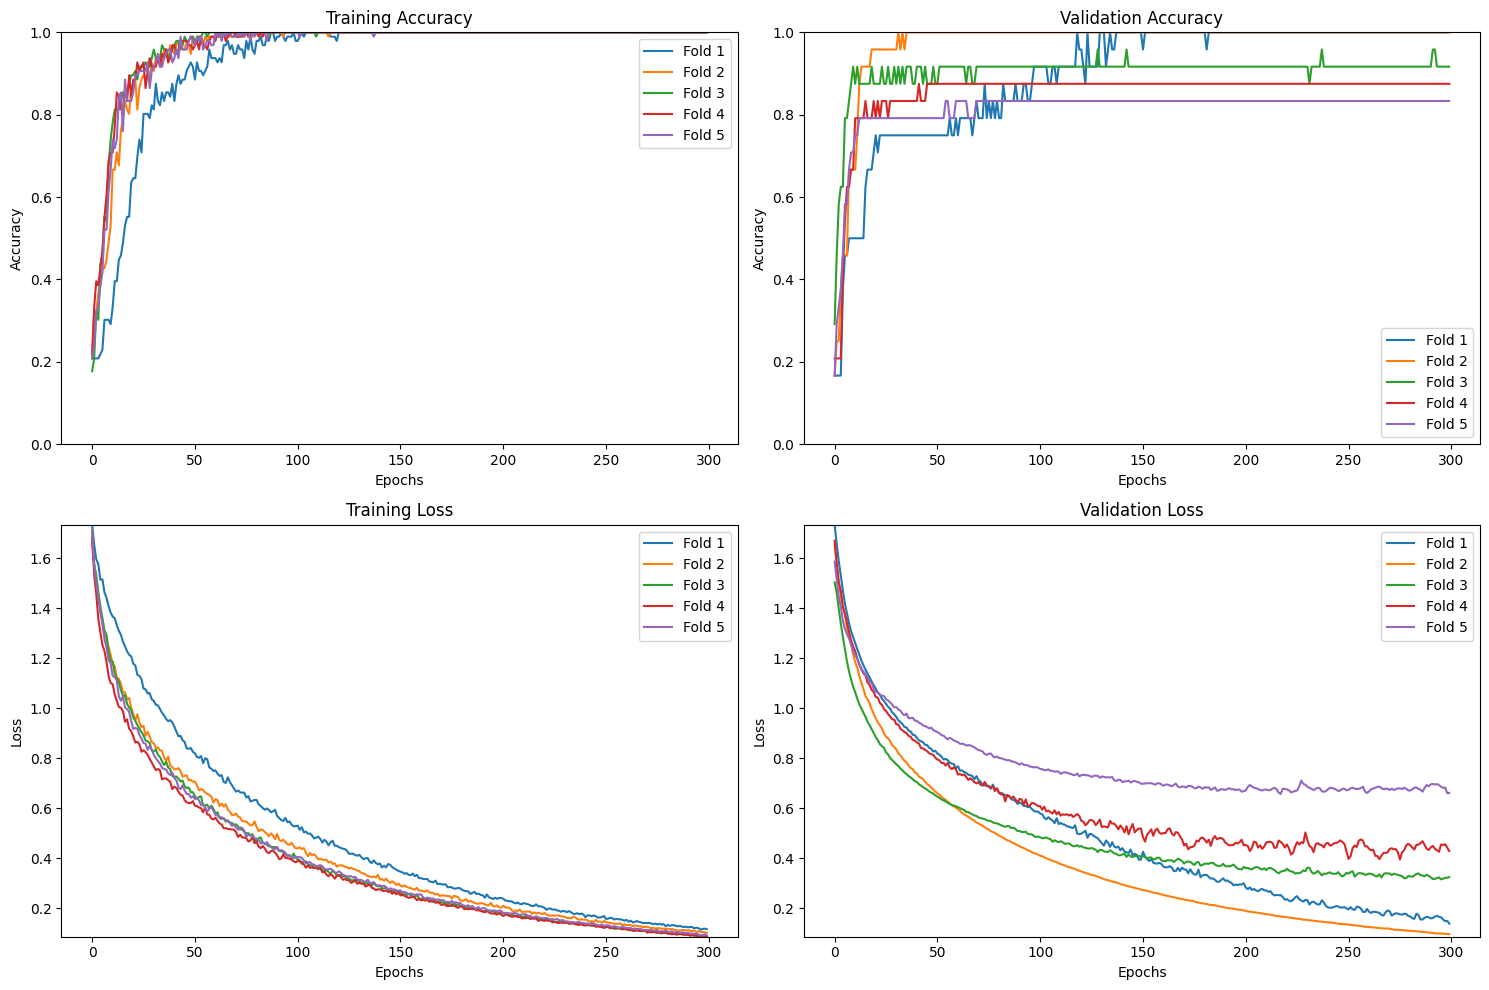

In [28]:
crossvalidate(df_smote, model2, predictors, 'class', kf)

As in bacteria dataset this approach is better than withour oversampling but we have to cosnider same problems as before, in addition accuracy is worse than for bacteria dataset, we will check resutls for test dataset now.

In [29]:
reset_weights(model2)
X_train_val = df_smote[predictors].values
y_train_val = keras.utils.to_categorical(df_smote['class'].values)
X_test = test_df[predictors].values
y_test = keras.utils.to_categorical(test_df['class'].values)
X_train_val.shape, y_train_val.shape, X_test.shape, y_test.shape


((120, 6368), (120, 5), (10, 6368), (10, 5))

In [30]:
history2 = model2.fit(X_train_val, y_train_val, validation_data = (X_test, y_test), epochs=500, callbacks=[es_callback], verbose=1)


Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1998 - loss: 1.7940 - val_accuracy: 0.1000 - val_loss: 1.7196
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1998 - loss: 1.6492 - val_accuracy: 0.1000 - val_loss: 1.6587
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2031 - loss: 1.5979 - val_accuracy: 0.1000 - val_loss: 1.6455
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2325 - loss: 1.5673 - val_accuracy: 0.1000 - val_loss: 1.6485
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2344 - loss: 1.5173 - val_accuracy: 0.1000 - val_loss: 1.6723
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3050 - loss: 1.4600 - val_accuracy: 0.1000 - val_loss: 1.6719
Epoch 7/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3244 - loss: 1.4212 - val_accuracy: 0.0000e+00 - val_loss: 1.6681
Epoch 8/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3329 - loss: 1.4149 - val_accuracy: 0.0000e+00 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6000 - loss: 1.1432
[1.1431553363800049, 0.6000000238418579]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted values: [2 0 3 0 0 0 0 0 0 0]
True values: [1 0 4 0 2 0 0 0 0 3]


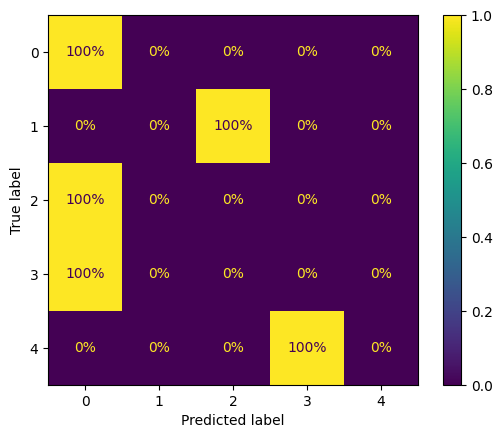

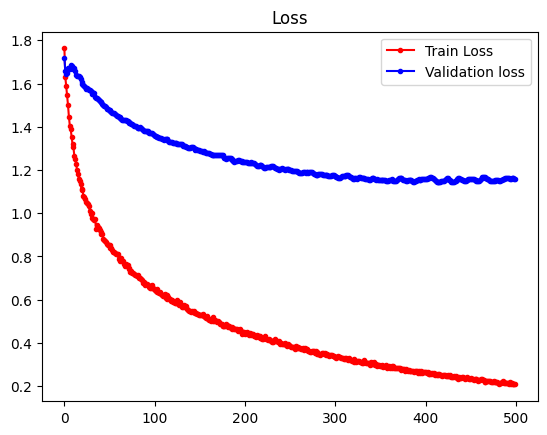

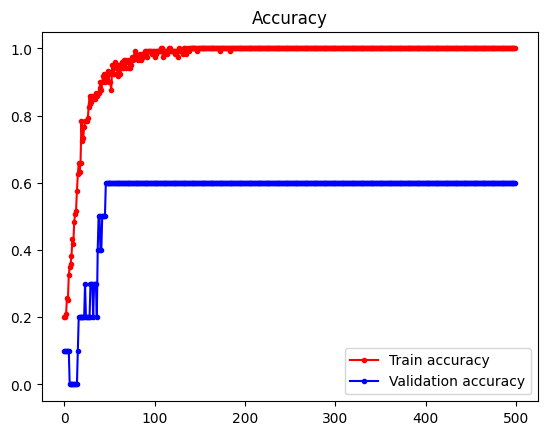

In [31]:
evaluate_model(model2,history2,test_df[predictors] , keras.utils.to_categorical(test_df['class']))

Here unfortunetelly we can see that model didnt learn anything and jsut predicted everything to class 0, the issue of overrepresentation was not present here, so the possible solution is that its much harder to make this kind of prediction based on KEGG dataset than on bacteria dataset. We will now move to best approach from previous analisis:

### Oversampling all of the classes in 5 class classification for both timepoints


In [32]:
train_val_df.shape, test_df.shape

((40, 6372), (10, 6372))

In [33]:
empty_class = pd.DataFrame(0, index=range(40),columns=train_val_df.columns)
#empty_class[] = np.random.rand(40, empty_class.shape[1])
empty_class['pond'] = 9


In [34]:
train_val_df_empty_class = pd.concat([train_val_df, empty_class], axis=0)

In [35]:
smote = SMOTE(random_state=111)
X = train_val_df_empty_class[predictors].values
y = train_val_df_empty_class['pond']

In [36]:
X.shape, y.shape

((80, 6368), (80,))

In [37]:
X_smote, y_smote = smote.fit_resample(X, y)
y_smote.shape

(240,)

In [38]:
df_smote = pd.concat([pd.DataFrame(X_smote, columns=predictors), pd.DataFrame(y_smote, columns=['pond'])], axis=1)
df_smote_cleared = df_smote[df_smote['pond'] != 9]
df_smote_cleared.reset_index(drop=True, inplace=True)
print(df_smote_cleared.shape)
df_smote_cleared['pond'].value_counts()

(200, 6369)


pond
1    40
0    40
4    40
3    40
2    40
Name: count, dtype: int64

(80, 6368) (80,)
(240, 6368) (240,)
Number of classes: 5
training for 1 subset


C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0222 
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/stepWARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000201AFCBCA40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
predicted classes:       [1 4 4 2 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 4 4 4 4
 4 4 4]
true validation cl

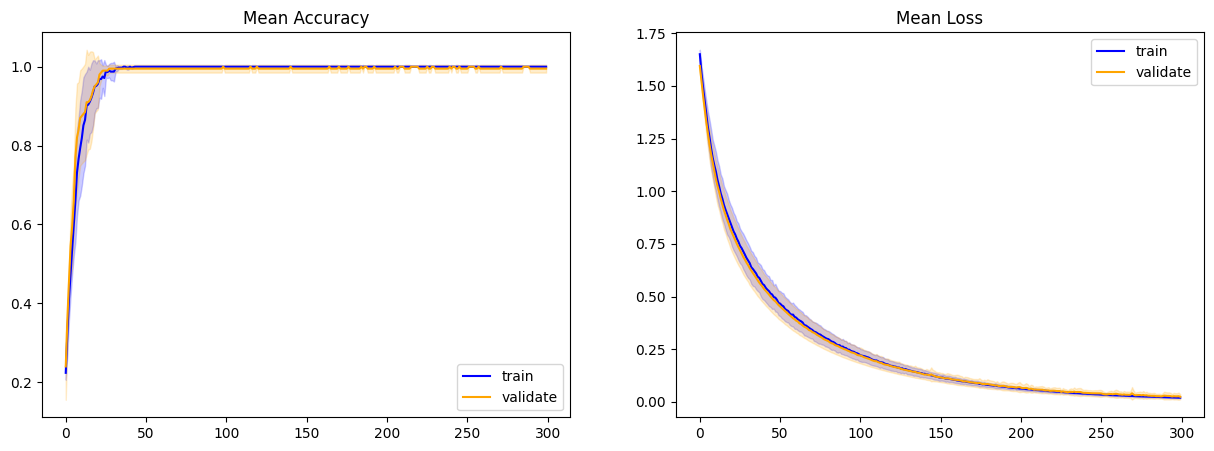

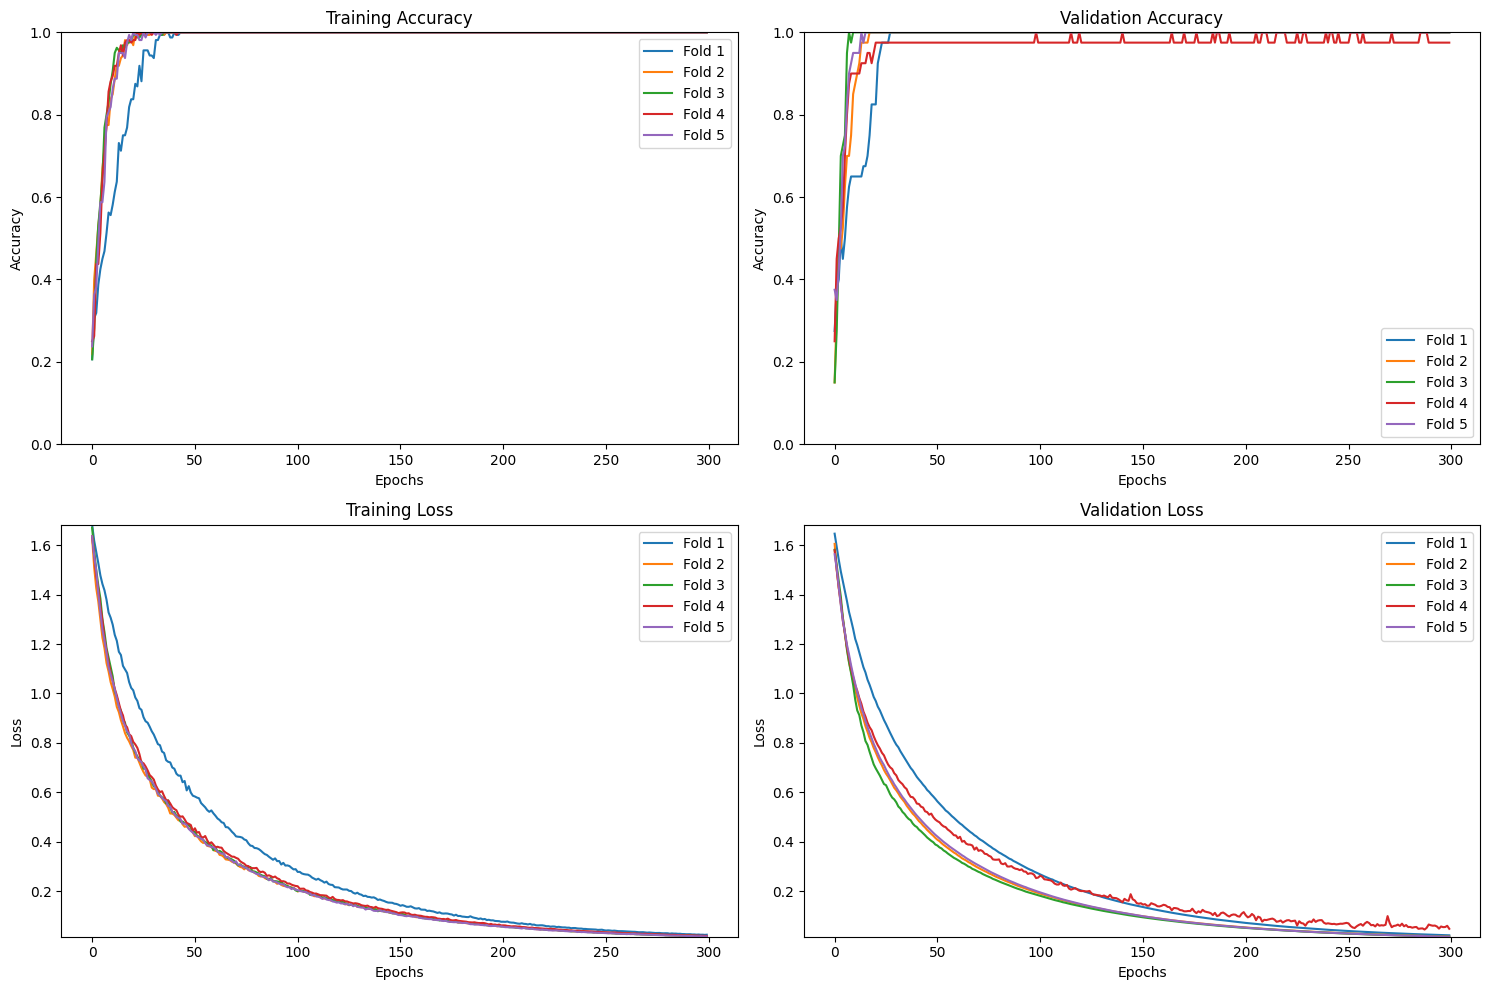

In [39]:
print(X.shape, y.shape)
print(X_smote.shape, y_smote.shape)

model3 = keras.Sequential()
model3.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))
model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(64, activation ='sigmoid'))
model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(16, activation ='sigmoid'))
model3.add(keras.layers.Dense(5, activation ='softmax'))

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model3.compile(optimizer = optimizer, loss = loss, metrics=metrics)
crossvalidate(df_smote_cleared, model3, predictors, 'pond', kf)

In [40]:
X = df_smote_cleared[predictors].values
y = keras.utils.to_categorical(df_smote_cleared['pond'].values)
y_test = keras.utils.to_categorical(test_df['pond'].values)
X_test = test_df[predictors].values
reset_weights(model3)   

history5 = model3.fit(X, y, epochs=300, batch_size=5,validation_data=(X_test, y_test), verbose=1, callbacks=[es_callback])

Epoch 1/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2467 - loss: 1.6824 - val_accuracy: 0.2000 - val_loss: 1.6175
Epoch 2/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3282 - loss: 1.5748 - val_accuracy: 0.3000 - val_loss: 1.6280
Epoch 3/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3387 - loss: 1.5291 - val_accuracy: 0.4000 - val_loss: 1.6214
Epoch 4/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4916 - loss: 1.4380 - val_accuracy: 0.4000 - val_loss: 1.6199
Epoch 5/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5890 - loss: 1.3342 - val_accuracy: 0.4000 - val_loss: 1.5827
Epoch 6/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6187 - loss: 1.2900 - val_accuracy: 0.4000 - val_loss: 1.5415
Epoch 7/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6714 - loss: 1.2393 - val_accuracy: 0.4000 - val_loss: 1.5172
Epoch 8/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7422 - loss: 1.1816 - val_accuracy: 0.4000 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2000 - loss: 1.6175
[1.6175334453582764, 0.20000000298023224]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted values: [2 2 2 2 2 2 3 2 2 2]
True values: [1 0 4 2 2 3 0 3 1 3]


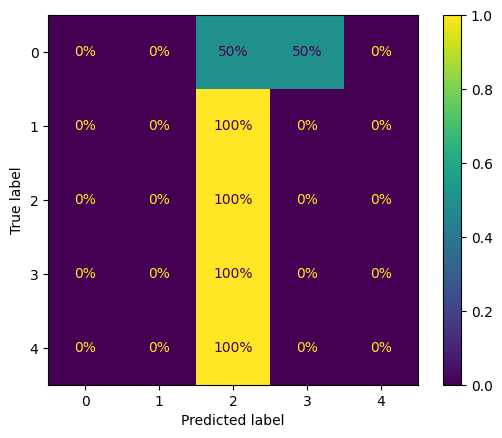

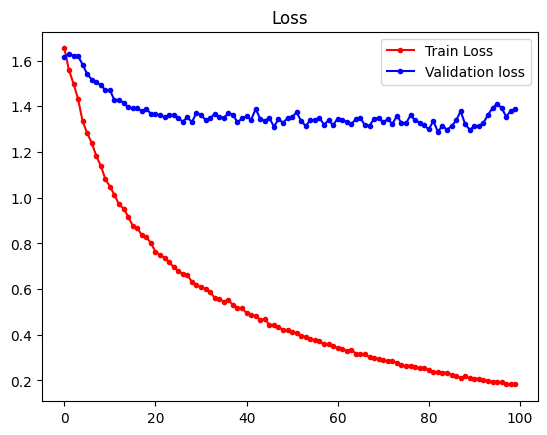

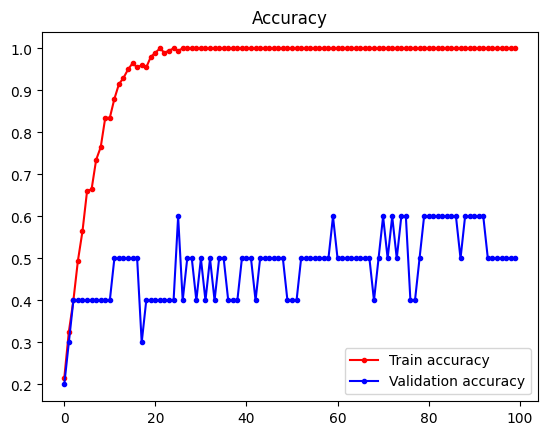

In [41]:
evaluate_model(model3, history5, X_test, y_test)

We can see simillar issues to previous classification approach, model is behaving much worse than for batcteria dataset. So if we are using same architecture results for KEGG paths dataset are much worse in comparison to bacteria dataset. Again issue of small number of original samples is probably causing most of the problems but we can see that model is having much harder time with KEGG dataset.

## XGBoost analysis

For comparison we will replicate our analysis use XGBoost which is based on Gradient Boosting and utilising Decision trees, we could use Random forests but this prooved to be a better approach for smaller dataset and we dont require faster and better computing performance that are offered by random forests.

In [58]:
import xgboost as xgb

### Using tp 0 and tp1 class0 as controll without oversampling

In [70]:
y_train = train_val_df['class'].values
y_test = test_df['class'].values
X_train = train_val_df[predictors].values
X_test = test_df[predictors].values
y_train.shape, y_test.shape, X_train.shape, X_test.shape

((40,), (10,), (40, 6368), (10, 6368))

We will use custom weights to account for class imbalance 

In [103]:
class_weights = {i: len(y_train) / (len(np.unique(y_train)) * np.sum(y_train == i)) for i in np.unique(y_train)}
sample_weights = np.array([class_weights[i] for i in y_train])

In [106]:
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights)
dtest = xgb.DMatrix(X_test, label=y_test)

In [107]:
params = {
    'objective': 'multi:softmax',
    'num_class': 5,
    'max_depth': 3, # maximum deepth of the tree, used to controll complexity of the model
    'eta': 0.1,
    'seed': 111

}

In [108]:
bst = xgb.train(params, dtrain, num_boost_round=100)

In [109]:
xgb_pred = bst.predict(dtest)
xgb_acc = accuracy_score(y_test, xgb_pred)

In [110]:
print(y_test)
print(xgb_pred)
print(xgb_acc)

[1. 0. 4. 0. 2. 0. 0. 0. 0. 3.]
[2. 0. 0. 1. 3. 0. 2. 0. 0. 1.]
0.4


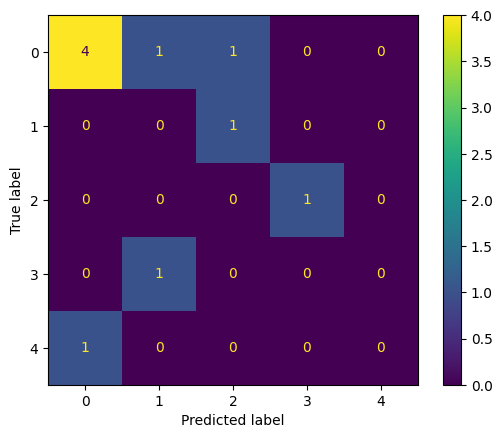

In [111]:
cm = confusion_matrix(y_test, xgb_pred)
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3,4]).plot()

For this short analysis we can see that xgboost model didnt perform much better.

### Using tp 0 and tp1 class0 as controll with oversampling

In [ ]:
df_smote['class'].value_counts()
X_smote = df_smote[predictors].values
y_smote = df_smote['class'].values

class
0    24
4    24
3    24
1    24
2    24
Name: count, dtype: int64

In [129]:
dtrain = xgb.DMatrix(X_smote, label=y_smote)
dtest = xgb.DMatrix(X_test, label=y_test)
params = {
    'objective': 'multi:softmax',
    'num_class': 5,
    'max_depth': 3, # maximum deepth of the tree, used to controll complexity of the model
    'eta': 0.1,
    'seed': 111

}

bst2 = xgb.train(params, dtrain, num_boost_round=100)

xgb_pred = bst2.predict(dtest)
xgb_acc = accuracy_score(y_test, xgb_pred)

In [130]:
print(y_test)
print(xgb_pred)
print(xgb_acc)

[1. 0. 4. 0. 2. 0. 0. 0. 0. 3.]
[1. 0. 0. 1. 3. 0. 0. 0. 0. 1.]
0.6


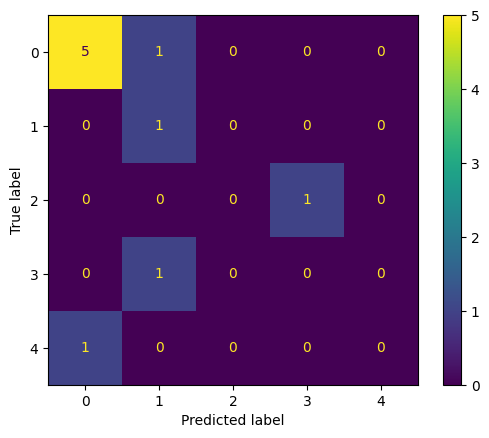

In [ ]:
cm = confusion_matrix(y_test, xgb_pred)
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3,4]).plot()

As we can note here, oversampling didn't really change anything and the results from the model are still poor, The issue might be the same with low number of samples, but it may also prove that the differencess between setups defined here in class are too litle or non existant at all. We will now test other approach and see if we can find anything 

### Classifying only ponds for both timepoints

In [149]:

train_val_df.shape, test_df.shape

((40, 6372), (10, 6372))

In [150]:
dtrain = xgb.DMatrix(X_train, label=train_val_df['pond'].values)  
dtest = xgb.DMatrix(X_test, label=test_df['pond'].values)
params = {
    'objective': 'multi:softmax',
    'num_class': 5,
    'max_depth': 3, # maximum deepth of the tree, used to controll complexity of the model
    'eta': 0.1,
    'seed': 111

}

bst2 = xgb.train(params, dtrain, num_boost_round=100)

xgb_pred = bst2.predict(dtest)
xgb_acc = accuracy_score(test_df['pond'].values, xgb_pred)

[1 0 4 2 2 3 0 3 1 3]
[1. 4. 2. 1. 1. 4. 0. 2. 1. 4.]
0.3


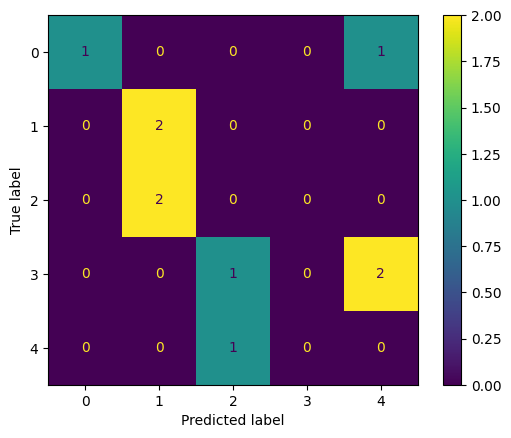

In [153]:
print(test_df['pond'].values)
print(xgb_pred)
print(xgb_acc)

cm = confusion_matrix(test_df['pond'].values, xgb_pred)
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3,4]).plot()

### Modeling only second timepoint

In [147]:
df_second_tp = df[df['timepoint'] == 1]
df_second_tp.shape

df_2tp_train, df_2tp_test = train_test_split(df_second_tp, test_size=5, random_state=111, stratify=df_second_tp['pond'])
print(df_2tp_train.shape, df_2tp_test.shape)
X_2_train = df_2tp_train[predictors].values
y_2_train = df_2tp_train['pond'].values
X_2_test = df_2tp_test[predictors].values
y_2_test = df_2tp_test['pond'].values



(20, 6372) (5, 6372)


In [155]:
dtrain = xgb.DMatrix(X_2_train, label=y_2_train)  
dtest = xgb.DMatrix(X_2_test, label=y_2_test)
params = {
    'objective': 'multi:softmax',
    'num_class': 5,
    'max_depth': 3, # maximum deepth of the tree, used to controll complexity of the model
    'eta': 0.1,
    'seed': 111

}

bst3 = xgb.train(params, dtrain, num_boost_round=100)

xgb_pred = bst3.predict(dtest)
xgb_acc = accuracy_score(y_2_test, xgb_pred)

[2 4 1 0 3]
[4. 0. 0. 2. 4.]
0.0


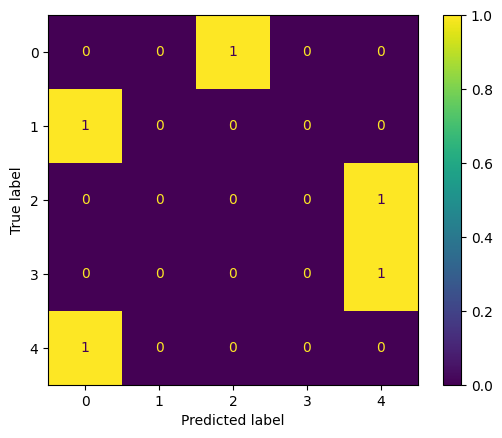

In [157]:
print(y_2_test)
print(xgb_pred)
print(xgb_acc)

cm = confusion_matrix(y_2_test, xgb_pred)
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3,4]).plot()

### Conclusions from XGBoost
The results from the XGBoost model are comparable to those obtained with neural networks, yielding unsatisfactory performance across our analyses, with accuracy levels close to random choice. This suggests that the KEGG dataset may be less informative than the bacterial family dataset or that the sample size is insufficient given the high dimensionality of this dataset. Consequently, the analysis of the Sediment KEGG pathways dataset remains inconclusive, indicating that deep learning techniques may not be effective in extracting meaningful results from this dataset under current conditions.